# PTC Extract Plotting

Contact author: Alex Broughton


## Introduction

Goals:
- Inspect/plot a PTC from ptcExtract data products

## 1.0 Set Up

In [1]:
! eups list -s | grep lsst_distrib
! eups list -s | grep ip_isr
! eups list -s | grep cp_pipe

lsst_distrib          g4213664e8e+0dcb05a918 	current w_2023_47 setup
ip_isr                g5bb47c1068+ae6a8c18b9 	current w_2023_47 setup
cp_pipe               gee0cc65525+36a99e9d86 	current w_2023_47 setup


In [2]:
### Import packages:
from lsst.daf.butler import Butler
from lsst.obs.lsst import LsstCam
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
import numpy as numpy
from lsst.ip.isr.isrTask import IsrTask

matplotlib.rcParams.update({'font.size': 13})
#plt.style.use('tableau-colorblind10')

# Set up some plotting defaults:

params = {'axes.labelsize': 13,
          'font.size': 12,
          'legend.fontsize': 12,
          'xtick.major.width': 1.5,
          'xtick.minor.width': 1,
          'xtick.major.size': 6,
          'xtick.minor.size': 3,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 1.5,
          'axes.linewidth': 1.5,
          'axes.labelweight': 1.5,
          'axes.titleweight': 1.5,
          'ytick.major.width': 1.5,
          'ytick.minor.width': 1,
          'ytick.major.size': 6,
          'ytick.minor.size': 3,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [7, 7],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

f = "5" + 1

In [3]:
def chi2_ndof(ptc, AMP):
        """
        returns the array of chi2/ndof contributions indexed by i and j for single AMP
    
        """
        gain = ptc.gain[AMP]
        n = ptc.noiseMatrix[AMP][0][0]
        if np.isnan(n):
            n = ptc.noise[AMP]

        expIdMask = ptc.expIdMask[AMP]
        mask_extended = (ptc.rawMeans[AMP]*gain > 0.2e5) * (ptc.rawMeans[AMP]*gain < .6e5)                              
        mask = expIdMask * mask_extended

        data = (ptc.covariances[AMP][mask] - n/gain**2) * (gain**2)
        model = (ptc.covariancesModel[AMP][mask] - n/gain**2) * (gain**2)
        w = (ptc.covariancesSqrtWeights[AMP][mask] / gain)**2

        mask = w != 0
        ndof = mask.sum(axis=0)-2
        # for 0,0, count-3 is more accurate:
        ndof[0,0] -= 1

        for i in range(ndof.shape[0]):
            for j in range(ndof.shape[1]):
                if not i==0 and not j==0:
                    ndof[i][j] *= 2

        chi2_ndof = (((model-data)**2)*w).sum(axis=0)/ndof
        
        return chi2_ndof
    
def cov_direct_value(diff ,w, dx,dy):
    (ncols,nrows) = diff.shape
    if dy>=0 :
        im1 = diff[dy:, dx:]
        w1 = w[dy:, dx:]
        im2 = diff[:ncols-dy, :nrows-dx]
        w2=w[:ncols-dy, :nrows-dx]
    else:
        im1 = diff[:ncols+dy, dx:]
        w1 = w[:ncols+dy, dx:]
        im2 = diff[-dy:, :nrows-dx]
        w2 = w[-dy:, :nrows-dx]
    w_all = w1*w2
    npix = w_all.sum()
    im1_times_w = im1*w_all
    s1 = im1_times_w.sum()/npix
    s2 = (im2*w_all).sum()/npix
    p = (im1_times_w*im2).sum()/npix
    cov = p-s1*s2
    return cov,npix

def compute_cov(diff, w, fft_shape, maxrange) :
    """
    diff : image to compute the covariance of
    w : weights (0 or 1) of the pixels of diff
    fft_shape : the actual shape of the DFTs
    maxrange: last index of the covariance to be computed
    returns cov[maxrange, maxrange], npix[maxrange,maxrange]
    """
    assert(fft_shape[0]>diff.shape[0]+maxrange)
    assert(fft_shape[1]>diff.shape[1]+maxrange)
    # for some reason related to numpy.fft.rfftn,
    # the second dimension should be even, so
    my_fft_shape = fft_shape
    if fft_shape[1] %2 == 1 :
        my_fft_shape = (fft_shape[0], fft_shape[1]+1)
    # FFT of the image
    tim = np.fft.rfft2(diff*w, my_fft_shape)
    # FFT of the mask
    tmask = np.fft.rfft2(w, my_fft_shape)
    # three inverse transforms:
    pcov = np.fft.irfft2(tim*tim.conjugate())
    pmean= np.fft.irfft2(tim*tmask.conjugate())
    pcount= np.fft.irfft2(tmask*tmask.conjugate())
    # now evaluate covariances and numbers of "active" pixels
    cov = np.ndarray((maxrange,maxrange))
    npix = np.zeros_like(cov)
    for dx in range(maxrange) :
        for dy in range(maxrange) :
            # compensate rounding errors
            npix1 = int(round(pcount[dy,dx]))
            cov1 = pcov[dy,dx]/npix1-pmean[dy,dx]*pmean[-dy,-dx]/(npix1*npix1)
            if (dx == 0 or dy == 0):
                cov[dy,dx] = cov1
                npix[dy,dx] = npix1
                continue
            npix2 = int(round(pcount[-dy,dx]))
            cov2 = pcov[-dy,dx]/npix2-pmean[-dy,dx]*pmean[dy,-dx]/(npix2*npix2)
            cov[dy,dx] = 0.5*(cov1+cov2)
            npix[dy,dx] = npix1+npix2
    return cov,npix


def measureMeanVarCov(f1, f2):
    """Calculate the mean of each of two exposures and the variance
    and covariance of their difference. The variance is calculated
    via afwMath, and the covariance via the methods in Astier+19
    (appendix A). In theory, var = covariance[0,0]. This should
    be validated, and in the future, we may decide to just keep
    one (covariance).

    Parameters
    ----------
    im1Area : `lsst.afw.image.maskedImage.MaskedImageF`
        Masked image from exposure 1.
    im2Area : `lsst.afw.image.maskedImage.MaskedImageF`
        Masked image from exposure 2.
    imStatsCtrl : `lsst.afw.math.StatisticsControl`
        Statistics control object.
    mu1: `float`
        Clipped mean of im1Area (ADU).
    mu2: `float`
        Clipped mean of im2Area (ADU).

    Returns
    -------
    mu : `float` or `NaN`
        0.5*(mu1 + mu2), where mu1, and mu2 are the clipped means
        of the regions in both exposures. If either mu1 or m2 are
        NaN's, the returned value is NaN.
    varDiff : `float` or `NaN`
        Half of the clipped variance of the difference of the
        regions inthe two input exposures. If either mu1 or m2 are
        NaN's, the returned value is NaN.
    covDiffAstier : `list` or `NaN`
        List with tuples of the form (dx, dy, var, cov, npix), where:
            dx : `int`
                Lag in x
            dy : `int`
                Lag in y
            var : `float`
                Variance at (dx, dy).
            cov : `float`
                Covariance at (dx, dy).
            nPix : `int`
                Number of pixel pairs used to evaluate var and cov.

        If either mu1 or m2 are NaN's, the returned value is NaN.
    """
    
    #h1 = fits.open(f1)
    #h2 = fits.open(f2)
    mu1 = np.mean(f1.image.array)
    mu2 = np.mean(f2.image.array)
    mu = 0.5*(mu1 + mu2)
    #h1.close()
    #h2.close()
    
    import lsst.afw.math as afwMath
    #from lsst.afw.image.maskedImage import MaskedImageF
    from lsst.cp.pipe.utils import (arrangeFlatsByExpTime, arrangeFlatsByExpId,
                                arrangeFlatsByExpFlux, sigmaClipCorrection,
                                CovFastFourierTransform)
    
    # Take difference of pairs
    # symmetric formula: diff = (mu2*im1-mu1*im2)/(0.5*(mu1+mu2))
    
    im1Area = f1.getMaskedImage()
    im2Area = f2.getMaskedImage()
    
    temp = im2Area.clone()
    temp *= mu1
    diffIm = im1Area.clone()
    diffIm *= mu2
    diffIm -= temp
    diffIm /= mu
    
    imMaskVal = im1Area.getMask().getPlaneBitMask(['SUSPECT', 'BAD', 'NO_DATA', 'SAT'])
    imStatsCtrl = afwMath.StatisticsControl(5.5, 3, imMaskVal)

    # Variance calculation via afwMath
    varDiff = 0.5*(afwMath.makeStatistics(diffIm, afwMath.VARIANCECLIP, imStatsCtrl).getValue())
    
    # Covariances calculations
    # Get the pixels that were not clipped
    varClip = afwMath.makeStatistics(diffIm, afwMath.VARIANCECLIP, imStatsCtrl).getValue()
    meanClip = afwMath.makeStatistics(diffIm, afwMath.MEANCLIP, imStatsCtrl).getValue()
    cut = meanClip + 5.5*np.sqrt(varClip)
    unmasked = np.where(np.fabs(diffIm.image.array) <= cut, 1, 0)

    # Get the pixels in the mask planes of the difference image
    # that were ignored by the clipping algorithm
    wDiff = np.where(diffIm.getMask().getArray() == 0, 1, 0)
    # Combine the two sets of pixels ('1': use; '0': don't use)
    # into a final weight matrix to be used in the covariance
    # calculations below.
    w = unmasked*wDiff

    maxRangeCov = 8

    # Calculate covariances via FFT.
    shapeDiff = np.array(diffIm.image.array.shape)
    # Calculate the sizes of FFT dimensions.
    s = shapeDiff + maxRangeCov
    tempSize = np.array(np.log(s)/np.log(2.)).astype(int)
    fftSize = np.array(2**(tempSize+1)).astype(int)
    fftShape = (fftSize[0], fftSize[1])
    c = CovFastFourierTransform(diffIm.image.array, w, fftShape, maxRangeCov)

    # np.sum(w) is the same as npix[0][0] returned in covDiffAstier
    try:
        covDiffAstier = c.reportCovFastFourierTransform(maxRangeCov)
    except ValueError:
        # This is raised if there are not enough pixels.
        print("Not enough pixels covering the requested covariance range in x/y (%d)", 8)
        return np.nan, np.nan, None

    # Compare Cov[0,0] and afwMath.VARIANCECLIP covDiffAstier[0]
    # is the Cov[0,0] element, [3] is the variance, and there's a
    # factor of 0.5 difference with afwMath.VARIANCECLIP.
    thresholdPercentage = 1
    fractionalDiff = 100*np.fabs(1 - varDiff/(covDiffAstier[0][3]*0.5))
    if fractionalDiff >= thresholdPercentage:
        print("Absolute fractional difference between afwMatch.VARIANCECLIP and Cov[0,0] "
                         "is more than %f%%: %f", thresholdPercentage, fractionalDiff)

    return mu, varDiff, covDiffAstier

def makeCovArray(inputTuple, maxRangeFromTuple=8):
        """Make covariances array from tuple.

        Parameters
        ----------
        inputTuple : `numpy.ndarray`
            Structured array with rows with at least
            (mu, afwVar, cov, var, i, j, npix), where:
            mu : `float`
                0.5*(m1 + m2), where mu1 is the mean value of flat1
                and mu2 is the mean value of flat2.
            afwVar : `float`
                Variance of difference flat, calculated with afw.
            cov : `float`
                Covariance value at lag(i, j)
            var : `float`
                Variance(covariance value at lag(0, 0))
            i : `int`
                Lag in dimension "x".
            j : `int`
                Lag in dimension "y".
            npix : `int`
                Number of pixels used for covariance calculation.
        maxRangeFromTuple : `int`
            Maximum range to select from tuple.

        Returns
        -------
        cov : `numpy.array`
            Covariance arrays, indexed by mean signal mu.
        vCov : `numpy.array`
            Variance of the [co]variance arrays, indexed by mean signal mu.
        muVals : `numpy.array`
            List of mean signal values.
        """
        if maxRangeFromTuple is not None:
            cut = (inputTuple['i'] < maxRangeFromTuple) & (inputTuple['j'] < maxRangeFromTuple)
            cutTuple = inputTuple[cut]
        else:
            cutTuple = inputTuple
        # increasing mu order, so that we can group measurements with the
        # same mu
        muTemp = cutTuple['mu']
        ind = np.argsort(muTemp)

        cutTuple = cutTuple[ind]
        # should group measurements on the same image pairs(same average)
        mu = cutTuple['mu']
        xx = np.hstack(([mu[0]], mu))
        delta = xx[1:] - xx[:-1]
        steps, = np.where(delta > 0)
        ind = np.zeros_like(mu, dtype=int)
        ind[steps] = 1
        ind = np.cumsum(ind)  # this acts as an image pair index.
        # now fill the 3-d cov array(and variance)
        muVals = np.array(np.unique(mu))
        i = cutTuple['i'].astype(int)
        j = cutTuple['j'].astype(int)
        c = 0.5*cutTuple['cov']
        n = cutTuple['npix']
        v = 0.5*cutTuple['var']
        # book and fill
        cov = np.ndarray((len(muVals), np.max(i)+1, np.max(j)+1))
        var = np.zeros_like(cov)
        cov[ind, i, j] = c
        var[ind, i, j] = v**2/n
        var[:, 0, 0] *= 2  # var(v) = 2*v**2/N

        return cov, var, muVals

def getCovArray(muDiff, varDiff, covAstier):
    # Turn the tuples with the measured information
    # into covariance arrays.
    # covrow: (i, j, var (cov[0,0]), cov, npix)
    
    tags = [('mu', '<f8'), ('afwVar', '<f8'), ('cov', '<f8'), ('var', '<f8'), ('i', '<i8'), ('j', '<i8'), ('npix', '<i8')]
    
    tupleRows = [(mu, varDiff, c, v, i, j, n) for (i,j,v,c,n) in covAstier]
    tempStructArray = np.array(tupleRows, dtype=tags)

    covArray, vcov, _ = makeCovArray(tempStructArray)
    covSqrtWeights = np.nan_to_num(1./np.sqrt(vcov))
    
    return covArray[0], covSqrtWeights[0]

def fit_chi2_ndof(mus,data, model,covSqrtWeights):
    """
    returns the array of chi2/ndof contributions indexed by i and j 
    """

    #w = np.ones(ptc.covariancesSqrtWeights[amp][mask3].shape)
    mask_exps = (mus > 10000.)
    w = (covSqrtWeights[mask_exps])**2
    mask = (w != 0)
    ndof = mask.sum(axis=0)-2
    # for 0,0, count-3 is more accurate:
    ndof[0,0] -= 1
    for i in range(ndof.shape[0]):
        for j in range(ndof.shape[1]):
            if not i==0 and not j==0:
                ndof[i][j] *= 2

    chi2_ndof = (((model[mask_exps]-data[mask_exps])**2)*w).sum(axis=0)/ndof

    chi2_ndof[np.isnan(chi2_ndof)] = -0.1

    return chi2_ndof

def getC(flat1,flat2):
    camera = LsstCam.getCamera()
    detector = camera.get(23)
    amps = detector.getAmplifiers()
    ampNames = [_.getName() for _ in amps]
    amp = amps[ampNames=="C00"]
    ampRegion = amp.getBBox().erodedBy(10)
    
    flat1_ = flat1.exposure.getCutout(ampRegion)
    flat2_ = flat2.exposure.getCutout(ampRegion)
    
    mu, varDiff, covDiffAstier = measureMeanVarCov(flat1_, flat2_)
    #C,covSqrtWeights = getCovArray(mu, varDiff, covDiffAstier)
    
    return mu, varDiff, covDiffAstier


In [4]:
repo = "/repo/ir2"
butler = Butler(repo)
registry = butler.registry
#registry.refresh()

In [5]:
! ls /sdf/group/rubin/repo/ir2/u/abrought/ptc.13511.DM-41754.DM-41911.DM-41681/20231129T233517Z/cpPtcExtract/20231105/MC_C_20231105_000489


cpPtcExtract_LSSTCam_ef_43_MC_C_20231105_000489_R03_S12_u_abrought_ptc_13511_DM-41754_DM-41911_DM-41681_20231129T233517Z.fits


In [8]:
from astropy.io import fits
import glob

def getPtc(collection, AMP=0):

    rp = butler.get_repo_uri(repo)
    
    fs = glob.glob(rp.ospath + collection + "*/*/cpPtcExtract/*/*/*.fits", recursive=True)
    
    rawMeans = []
    covariances = []
    for i,f in enumerate(fs):
        h = fits.open(f)
        if not np.isnan(h[1].data['RAW_MEANS'][AMP]):
            rawMeans.extend(h[1].data['RAW_MEANS'][AMP])
            covariances.append(h[1].data['COVARIANCES'][AMP].reshape((15,15)))
    inds=np.argsort(rawMeans)
    rawMeans=np.asarray(rawMeans)[inds]
    covariances=np.asarray(covariances)[inds]

    return rawMeans, covariances

## 2.0 Plotting $C_{00}$

In [9]:
rawMeans, covariances=getPtc('u/abrought/ptc.13511.med_per_row.doParallelOverscan')

Text(0, 0.5, '$C_{00}$')

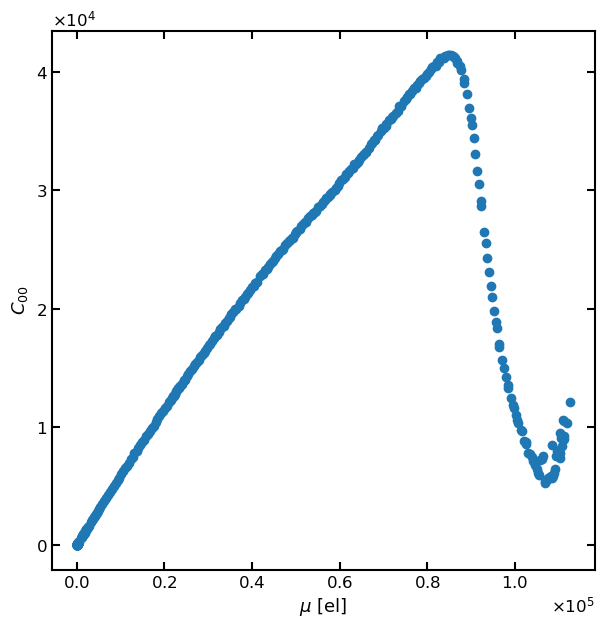

In [10]:
plt.scatter(rawMeans,covariances[:,0,0])
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
plt.xlabel(r"$\mu$ [el]")
plt.ylabel("$C_{00}$")

Text(0, 0.5, '$C_{00}$')

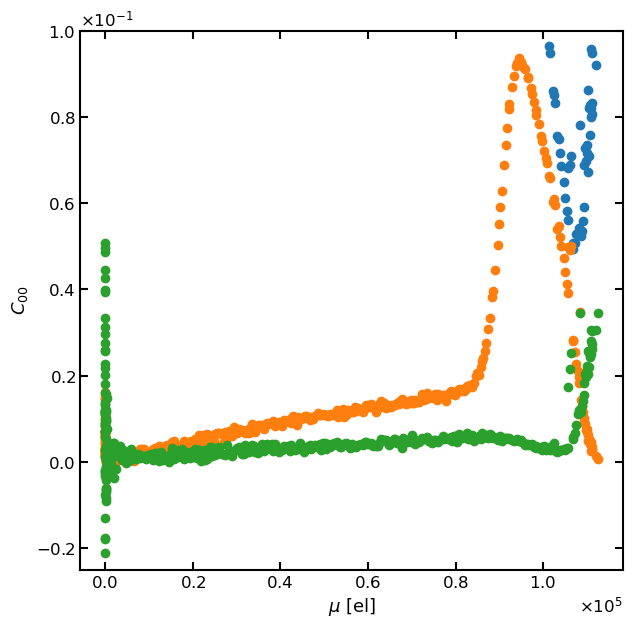

In [12]:
plt.scatter(rawMeans,covariances[:,0,0]/rawMeans)
plt.scatter(rawMeans,covariances[:,0,1]/rawMeans)
plt.scatter(rawMeans,covariances[:,1,0]/rawMeans)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
plt.xlabel(r"$\mu$ [el]")
plt.ylim(-.025,.1)
plt.ylabel("$C_{00}$")

In [13]:
ix = np.indices((15,15))
r=np.hypot(ix[0],ix[1])


In [14]:
rawMeans2, covariances2=getPtc('u/abrought/ptc.13511.med_per_row.doParallelOverscan')

In [ ]:
plt.scatter(r.ravel(),covariances[325].ravel(), label=f"{round(rawMeans[325])} adu")
plt.scatter(r.ravel(),covariances[300].ravel(), label=f"{round(rawMeans[300])} adu")
plt.scatter(r.ravel(),covariances[200].ravel(), label=f"{round(rawMeans[200])} adu")
plt.scatter(r.ravel(),covariances[100].ravel(), label=f"{round(rawMeans[100])} adu")
plt.scatter(r.ravel(),covariances[50].ravel(), label=f"{round(rawMeans[50])} adu")
plt.xscale('log')
plt.yscale('log')
plt.xlim(-1,60)
_ = plt.xticks([1,2,3,4,5,6,7,8,9,10,20,30,40,50,60],
              labels=[str(_) for _ in [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60]])
plt.ylabel("$C_{ij}$")
plt.xlabel("$\sqrt{i^2 + j^2}$")
plt.legend()

81200.5869974583 24085.18457244678


/tmp/ipykernel_14011/2655085523.py:6: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(-1,60)


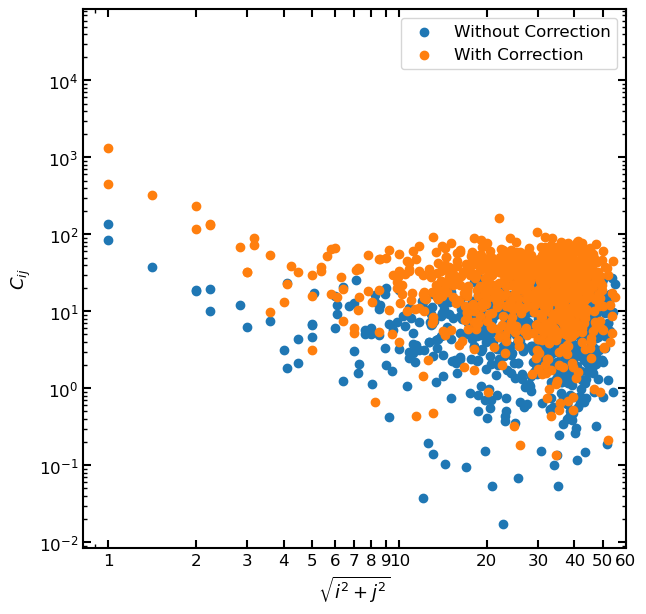

In [23]:
plt.scatter(r.ravel(),covariances2[300].ravel(), label=f"Without Correction")
print(rawMeans[300],rawMeans2[300])
plt.scatter(r.ravel(),covariances[300].ravel(), label=f"With Correction")
plt.xscale('log')
plt.yscale('log')
plt.xlim(-1,60)
_ = plt.xticks([1,2,3,4,5,6,7,8,9,10,20,30,40,50,60],
              labels=[str(_) for _ in [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60]])
plt.ylabel("$C_{ij}$")
plt.xlabel("$\sqrt{i^2 + j^2}$")
plt.legend()

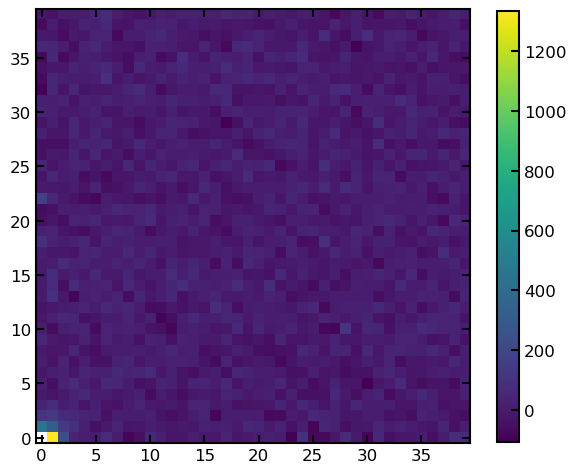

In [25]:
C = covariances[300]
C[0][0]=np.nan
plt.imshow(covariances[300],origin='lower')
plt.colorbar(shrink=.8)
#plt.xlim(-.5,10.5)
#plt.ylim(-.5,10.5)

In [188]:
covariances[100,0,1]

-0.04210051852243749

In [200]:
covariances[100,1,0]

17.266607036156273

## 3.0 Plotting $\Delta C_{00}/ C_{00}$

Text(0, 0.5, '$\\Delta C_{00} / C_{00}$')

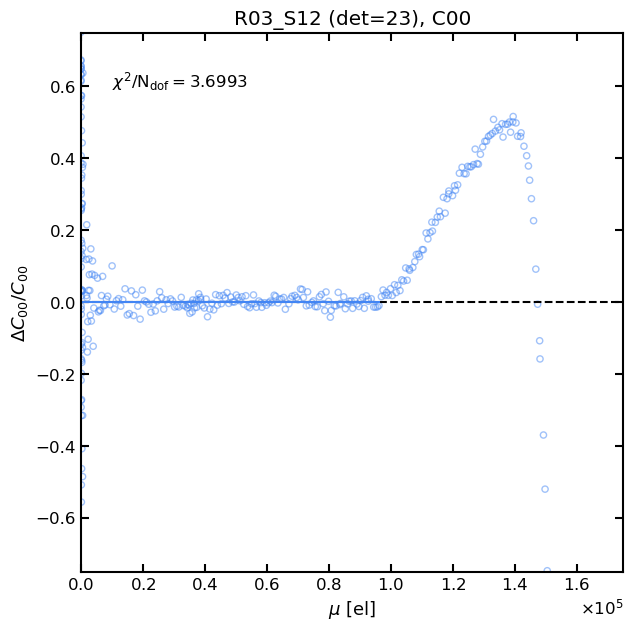

In [8]:
plt.axhline(0.0, linestyle="--", color="k")

plt.scatter(mu*g,(c00*g*g - c00_model*g*g)/c00_model*g*g, 
            marker="o", edgecolor="#4285F4", 
            s=20,  facecolor="None", 
            label="135211 (blue)", alpha=0.5)

plt.plot(mu[expIdMask]*g,
         (c00_model[expIdMask]*g*g - c00_model[expIdMask]*g*g)/c00_model[expIdMask]*g*g,
         "o-", ms=0, c="#4285F4")

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
plt.ylim(-0.75,0.75)
plt.xlim(0,1.75e5)
plt.xlabel(r"$\mu$ [el]")
plt.text(.1e5,.6,r"$\chi^2 / \mathrm{N_{dof}} =$" + str(round(chi2_ndof(ptc,AMP)[0][0],4)))
plt.title(f"{det_name} (det={det}), {AMP}")
plt.ylabel("$\Delta C_{00} / C_{00}$")

## 4.0 Plotting $\tilde{C}_{00}/ \mu^2$

In [17]:
plt.scatter(rawMeans2*g2,r2, marker="o", edgecolor="#4285F4", s=10,  facecolor="None", label="135211 (blue)", alpha=0.5)
#plt.plot(mu[expIdMask]*g,r_model[expIdMask], "o-", ms=0, c="#4285F4")
#plt.axhline(a[0,0], linestyle="--", color="k")

plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
plt.ylim(-2.0e-6,-.75e-6)
plt.xlim(0,1.75e5)
plt.xlabel(r"$\mu$ [el]")
plt.title(f"{det_name} (det={det}), {AMP}")
plt.ylabel("$C_{00}/\mu^2 - (\mu/g + n_{00}/g^{2})/\mu^2$")

NameError: name 'g2' is not defined

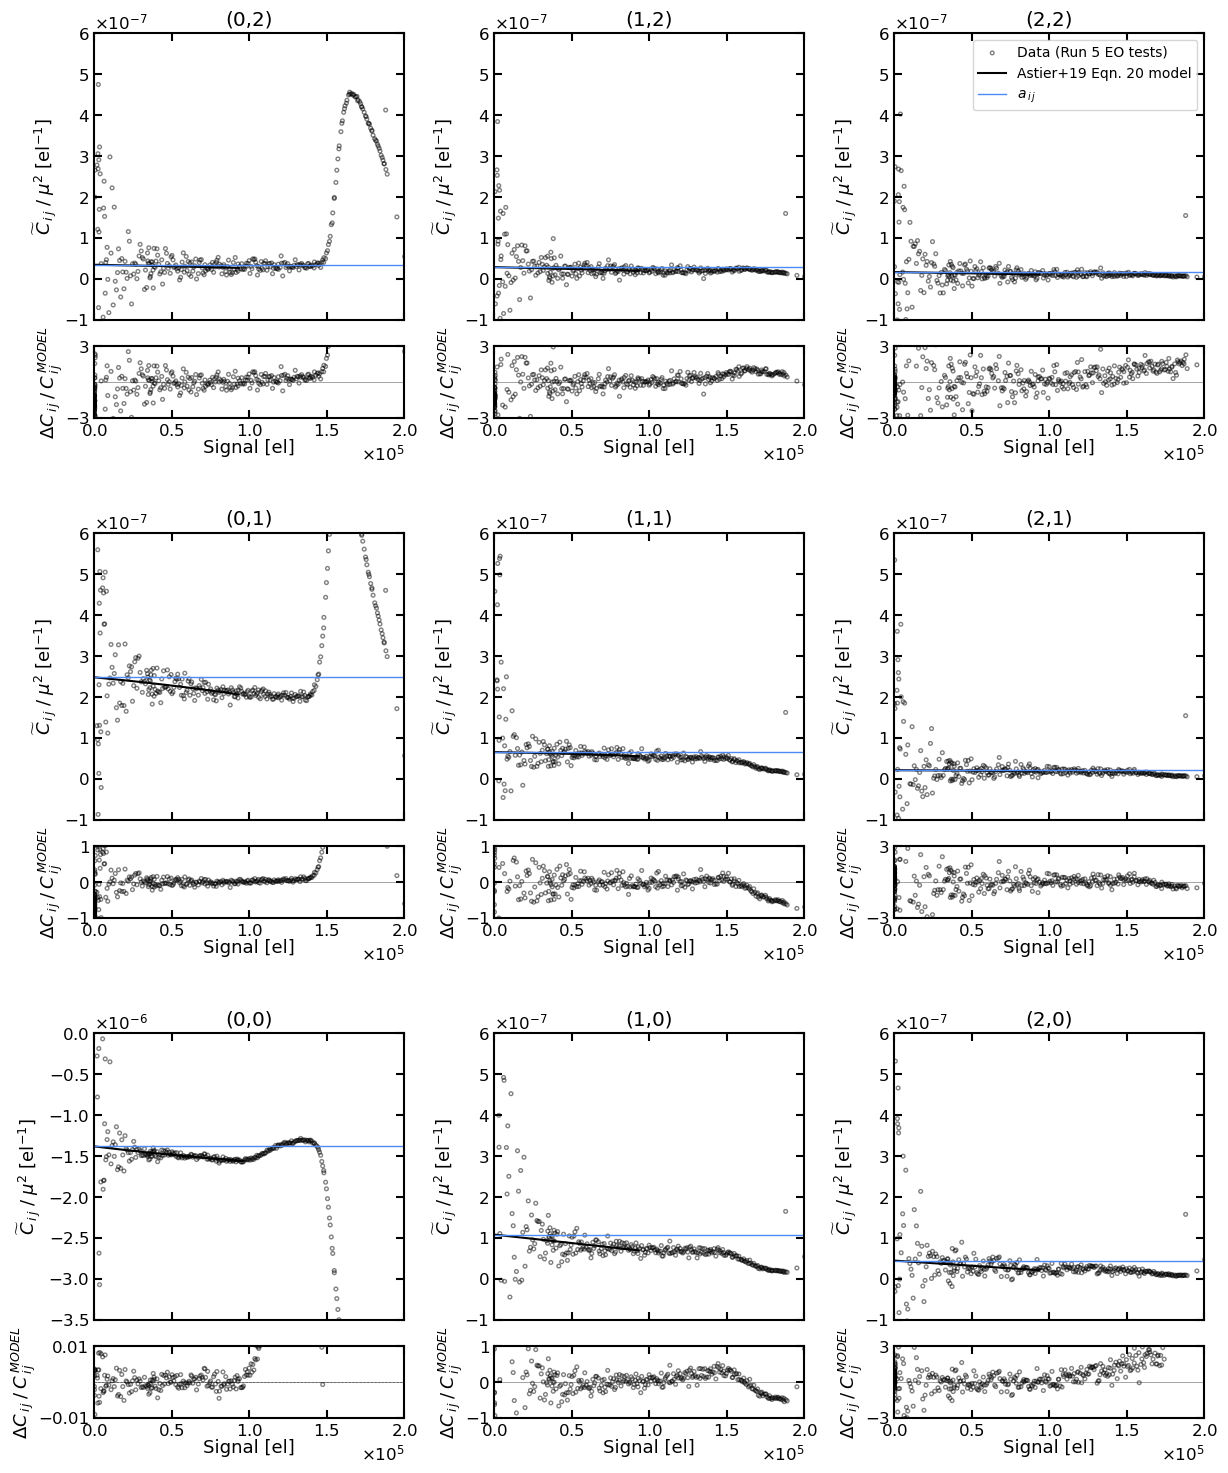

In [10]:
sensor="R03_S12"
det = 23
fa = 0.791
amp = 'C00'
import matplotlib.gridspec as gridspec
import sys
sys.path.append('/sdf/home/a/abrought/bin')
#from SpotAnalysis import *
#ptc_turnoffs, scti_turnoffs, pcti_turnoffs, moss, gains = getSensorData(sensor=sensor, detector=det)

camera = LsstCam().getCamera()
detector = camera.get(sensor)

def avg_dict(d, exclude_channels=[]):

        t = np.zeros((8,8))
        for k,channel in zip(d.values(), d.keys()):
            if channel in exclude_channels:
                continue

            t += k
        return t / len(d.values())

def avg_dict2(d, exclude_channels=[]):

        t = np.zeros((338,8,8))
        for k,channel in zip(d.values(), d.keys()):
            if channel in exclude_channels:
                continue

            t += k
        return t / len(d.values())


gains = []
for l, channel in enumerate(camera[0].getAmplifiers()):
    #print(l,channel.getName())
    gains.append(ptc.gain[channel.getName()])

fig = plt.figure(figsize=(12,15))
gs = gridspec.GridSpec(2, 1, height_ratios=[4,1], hspace=0.3*.5)
sub_fig = fig.subfigures(3, 3)
for i in range(3):
    for j in range(3): # 00->20 01->10
        ax1 = sub_fig[2-j][i].add_subplot(gs[0])
        ax2 = sub_fig[2-j][i].add_subplot(gs[1])
        l = 0
        mask = np.asarray(ptc.expIdMask[amp])
        n  = ptc.noiseMatrix[amp]
        g  = ptc.gain[amp] 
        mu = np.asarray(ptc.rawMeans[amp])
        C  = np.asarray(ptc.covariances[amp])[:,i,j]
        C_model = np.asarray(ptc.covariancesModel[amp])[:,i,j]
        if i==0 and j==0 and l==0:
            ax1.scatter(mu*g, (C / mu**2) - (mu/g + n[0][0]/g**2)/(mu**2), s=7,edgecolor="k", facecolor="None", alpha=0.5)
            ax1.plot(mu[mask]*g, (C_model[mask] / mu[mask]**2) - (mu[mask]/g + n[0][0]/g**2)/(mu[mask]**2), "-", color='k')
            #residual = ((C[mask] / mu[mask]**2) - (mu[mask]/g + n/g**2)/(mu[mask]**2) - ((C_model[mask] / mu[mask]**2) - (mu[mask]/g + n/g**2)/(mu[mask]**2))) / ((C_model[mask] / mu[mask]**2) - (mu[mask]/g + n/g**2)/(mu[mask]**2)) 
            #ax2.scatter(mu[mask]*g, residual, s=2, color='#4c8bf5', alpha=0.25)
            ax2.set_ylim(-0.2,0.2)
            ax2.set_xlim(0,2.0e5)
            #ax2.set_ylabel(r"$\frac{Data - Model}{Model}$", labelpad=0)
            ax1.set_ylim(-3.5e-6,0.0e-6)
            #ax1.set_title(r"$a_{00} = \frac{1}{\mu^2}\left [ C_{00} - \left ( \frac{\mu}{g} + \frac{n_{00}}{g^2}\right ) \right ]$")
            ax1.set_title(f'({i},{j})'.format(i,j))
        elif i==0 and j==0:
            ax1.scatter(mu*g, (C / mu**2) - (mu/g + n[0][0]/g**2)/(mu**2), s=7, edgecolor="k", facecolor="None", alpha=0.5)
        elif i==2 and j==2 and l==0:
            ax1.scatter(mu*g,  C / mu**2 - (n[i][j]/g**2)/mu**2 , s=7,edgecolor="k", facecolor="None", alpha=0.5, label="Data (Run 5 EO tests)")
            ax1.set_ylim(-1e-7,6e-7)
            ax1.set_title(f'({i},{j})'.format(i,j))
        else:

            ax1.scatter(mu*g,  C / mu**2  - (n[i][j]/g**2)/mu**2, s=7,edgecolor="k", facecolor="None", alpha=0.5)
            ax1.set_ylim(-1e-7,6e-7)
            ax1.set_title(f'({i},{j})'.format(i,j))
        
        #

        if i==0 and j==0:

            mask = np.asarray(ptc.expIdMask[amp])
            C  = np.asarray(ptc.covariances[amp])[:,i,j]
            C_model = np.asarray(ptc.covariancesModel[amp])[:,i,j]
            res1 = ((C / mu**2) - (mu/g + n[0][0]/g**2))
            res2 = ((C_model / mu**2) - (mu/g + n[0][0]/g**2))
            residual = (C - C_model) / C_model
            ax2.scatter(mu * ptc.gain[amp],residual, s=7,edgecolor="k", facecolor="None", alpha=0.5)

            ax2.set_xlim(0,2.0e5)
            ax2.set_ylabel(r"$\frac{Data - Model}{Model}$", labelpad=0)
            ax2.set_xlabel("Signal [el]")
        else:
            ax1.plot(mu[mask] * np.mean(gains),C_model[mask] / mu[mask]**2 - (n[i][j]/g**2)/mu[mask]**2 , "-", color='k', label="Astier+19 Eqn. 20 model")

            mask = np.asarray(ptc.expIdMask[amp])
            C  = np.asarray(ptc.covariances[amp])[:,i,j]
            C_model = np.asarray(ptc.covariancesModel[amp])[:,i,j]
            residual = ((C / mu**2) - (C_model / mu**2)) / (C_model / mu**2)
            ax2.scatter(mu * ptc.gain[amp],residual, s=7,edgecolor="k", facecolor="None", alpha=0.5)
            ax2.set_ylim(-1,1)
            ax2.set_xlim(0,2.0e5)
                
        if 2-j==0 or i==2:
            ax2.set_ylim(-3.0,3.0)
            ax2.set_yticks([-3.0,3.0])
            pass
        
        
        ax1.axhline(ptc.aMatrix[amp][i][j], color="#4c8bf5", linewidth=1, linestyle="-", label=r"$a_{\,i\,j}$")

        ax1.set_xlim(0,2.0e5)
        ax2.set_xlabel("Signal [el]", labelpad=-0.25)
        ax2.set_ylabel(r"$\Delta C_{\,i\,j}\:/\:C_{\,i\,j}^{\,MODEL}$", labelpad=0)
        ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        #ax1.xaxis.major.formatter._useMathText = True
        ax1.yaxis.major.formatter._useMathText = True
        
        # ax1.axvline(np.min(pcti_turnoffs) , linestyle=":", color="black", label="pCTI turnoff", alpha=0.5)
        # ax2.axvline(np.min(pcti_turnoffs) , linestyle=":", color="black", alpha=0.5)
        # ax1.axvline(np.min(ptc_turnoffs) , linestyle="--", color="black", label="PTC turnoff", alpha=0.5)
        # ax2.axvline(np.min(ptc_turnoffs) , linestyle="--", color="black", alpha=0.5)
        # ax1.axvline(np.min(scti_turnoffs) , linestyle="-", color="black", label="sCTI turnoff", alpha=0.5)
        # ax2.axvline(np.min(scti_turnoffs) , linestyle="-", color="black", alpha=0.5)
        
        ax2.axhline(0.0, linestyle="-", linewidth=0.5, color="k", alpha=0.5)
        
        if i==0 and j==0:
            ax2.axhline(0.0, linestyle="--", linewidth=0.5, color="k", alpha=0.5)
            ax2.set_ylim(-0.010,0.010)
            ax2.set_yticks([-0.01,0.01])
        #elif 2-j==1 and i==0:
        #    ax1.set_ylabel(r"$\widetilde{C}_{\,i\,j}\;/\;\mu^2$ [el$^{-1}$]")
        if i==2 and j==2:
            ax1.legend(frameon=True, ncol=1,fontsize=10, loc=1)
        plt.setp( ax1.get_xticklabels(), visible=False)
        ax2.ticklabel_format(axis="x", style="sci", scilimits=(0,0), useMathText=True)
        #ax1.set_title(f"$a_{{\:{i}\:{j}}}$")
        #ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
        ax1.set_ylabel(r"$\widetilde{C}_{\,i\,j}\;/\;\mu^2$ [el$^{-1}$]")
        

#axs[0][1].set_title(r'$a_{01}$')
#axs[0][2].set_title(r'$a_{02}$')
#axs[1][0].set_title(r'$a_{10}$')
#axs[2][0].set_title(r'$a_{20}$')
#axs[1][1].set_title(r'$a_{11}$')
#axs[2][2].set_title(r'$a_{22}$')
#axs[2][1].set_title(r'$a_{21}$')
#axs[1][2].set_title(r'$a_{12}$')
#axs[2][0].set_xlabel("Signal [el]")
#axs[2][1].set_xlabel("Signal [el]")
#axs[2][2].set_xlabel("Signal [el]")


## 6.0 PTC Comparison


In [13]:
def getPTCData(ptc):
    AMP="C00"
    mu = ptc.rawMeans[AMP]
    g = ptc.gain[AMP]
    expIdMask = ptc.expIdMask[AMP]
    c00 = ptc.rawVars[AMP]
    c00_model = ptc.covariancesModel[AMP][:,0,0]
    n = ptc.noiseMatrix[AMP][0,0]
    a = ptc.aMatrix[AMP]

    r = (c00 / mu**2) - (mu/g + n/g**2)/(mu**2)
    r_model = (c00_model / mu**2) - (mu/g + n/g**2)/(mu**2)
    
    return mu, g, expIdMask, c00, c00_model, n, a, r, r_model

ptc1 =  butler.get('ptc', detector=23, instrument='LSSTCam', 
                   collections='u/abrought/ptc.13511.DM-41754.DM-41681.condensed')
mu1, g1, expIdMask1, c001, c00_model1, n1, a1, r1, r_model1 = getPTCData(ptc1)

ptc2 =  butler.get('ptc', detector=23, instrument='LSSTCam', 
                   collections='u/abrought/ptc.13511.DM-41754.DM-41681.condensed.longRangeCovCorrOff.v2')
mu2, g2, expIdMask2, c002, c00_model2, n2, a2, r2, r_model2 = getPTCData(ptc2)





Text(0, 0.5, '$C_{00}^{corrected} - C_{00}$ $[el^2]$')

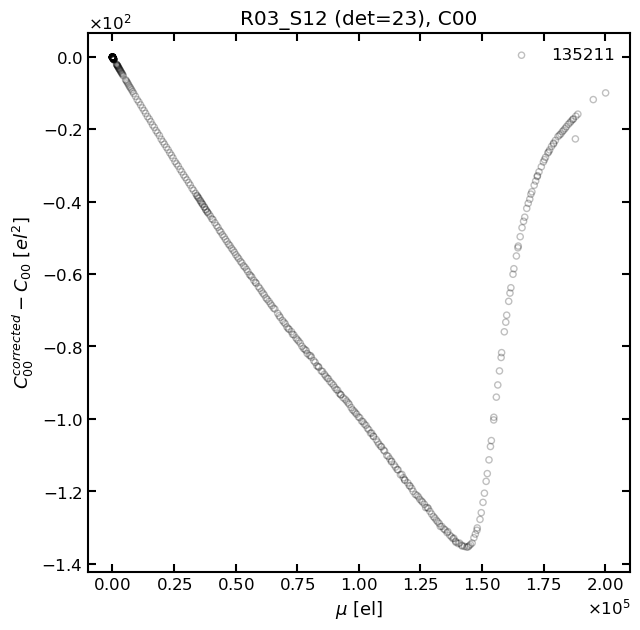

In [14]:
plt.scatter(mu2*g2,c001*g1*g1 - c002*g2*g2, marker="o", edgecolor="k", s=20,  alpha=.25,facecolor="None", label="135211")#,ptc.rawVars['C00']*ptc.gain['C00']*ptc.gain['C00'] / ptc.rawMeans['C00']*ptc.gain['C00'])
#plt.plot(mu2[expIdMask2]*g2,c00_model2[expIdMask2]*g2*g2, "o-", ms=0, c="orange")#,ptc.rawVars['C00']*ptc.gain['C00']*ptc.gain['C00'] / ptc.rawMeans['C00']*ptc.gain['C00'])
#plt.plot([0,1.75e5],[0,1.75e5], "k--")

plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
#plt.ylim(0,1.75e5)
#plt.xlim(0,1.75e5)
plt.xlabel(r"$\mu$ [el]")
plt.legend(frameon=False)
plt.title(f"{det_name} (det={det}), {AMP}")
plt.ylabel("$C_{00}^{corrected} - C_{00}$ $[el^2]$")

In [38]:
ptc1 =  butler.get('ptc', detector=23, instrument='LSSTCam', 
                   collections='u/abrought/ptc.13511')
mu1, g1, expIdMask1, c001, c00_model1, n1, a1, r1, r_model1 = getPTCData(ptc1)

ptc2 =  butler.get('ptc', detector=23, instrument='LSSTCam', 
                   collections='u/abrought/ptc.13511.doDeferredChargeFalse')
mu2, g2, expIdMask2, c002, c00_model2, n2, a2, r2, r_model2 = getPTCData(ptc2)

plt.scatter(mu1*g1,c001*g1*g1, marker="o", edgecolor="#4285F4", s=20,  facecolor="None", label="135211 (doDeferredCharge: True)", alpha=0.5)#,ptc.rawVars['C00']*ptc.gain['C00']*ptc.gain['C00'] / ptc.rawMeans['C00']*ptc.gain['C00'])
plt.plot(mu1[expIdMask1]*g1,c00_model1[expIdMask1]*g1*g1, "o-", ms=0, c="#4285F4")#,ptc.rawVars['C00']*ptc.gain['C00']*ptc.gain['C00'] / ptc.rawMeans['C00']*ptc.gain['C00'])
plt.plot([0,1.75e5],[0,1.75e5], "k--")

plt.scatter(mu2*g2,c002*g2*g2, marker="o", edgecolor="orange", s=20,  facecolor="None", label="135211 (doDeferredCharge: False)", alpha=0.5)#,ptc.rawVars['C00']*ptc.gain['C00']*ptc.gain['C00'] / ptc.rawMeans['C00']*ptc.gain['C00'])
plt.plot(mu2[expIdMask2]*g2,c00_model2[expIdMask2]*g2*g2, "o-", ms=0, c="orange")#,ptc.rawVars['C00']*ptc.gain['C00']*ptc.gain['C00'] / ptc.rawMeans['C00']*ptc.gain['C00'])
plt.plot([0,1.75e5],[0,1.75e5], "k--")

plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
plt.ylim(0,1.75e5)
plt.xlim(0,1.75e5)
plt.xlabel(r"$\mu$ [el]")
plt.title(f"{det_name} (det={det}), {AMP}")
plt.ylabel("$C_{00}$")

LookupError: Dataset ptc with data ID {instrument: 'LSSTCam', detector: 23} could not be found in collections u/abrought/ptc.13511.doDeferredChargeFalse.

Text(0, 0.5, '$C_{00}^{corrected} - C_{00}$ $[el^2]$')

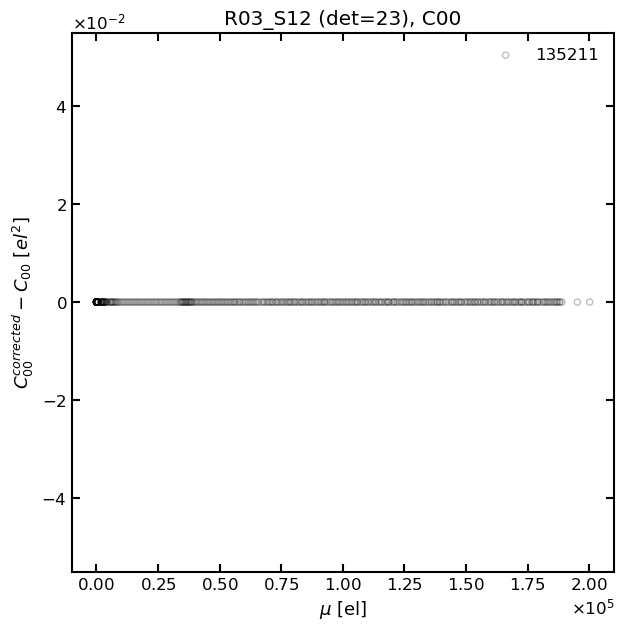

In [22]:
plt.scatter(mu2*g2,c001*g1*g1 - c002*g2*g2, marker="o", edgecolor="k", s=20,  alpha=.25,facecolor="None", label="135211")#,ptc.rawVars['C00']*ptc.gain['C00']*ptc.gain['C00'] / ptc.rawMeans['C00']*ptc.gain['C00'])
#plt.plot(mu2[expIdMask2]*g2,c00_model2[expIdMask2]*g2*g2, "o-", ms=0, c="orange")#,ptc.rawVars['C00']*ptc.gain['C00']*ptc.gain['C00'] / ptc.rawMeans['C00']*ptc.gain['C00'])
#plt.plot([0,1.75e5],[0,1.75e5], "k--")

plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
#plt.ylim(0,1.75e5)
#plt.xlim(0,1.75e5)
plt.xlabel(r"$\mu$ [el]")
plt.legend(frameon=False)
plt.title(f"{det_name} (det={det}), {AMP}")
plt.ylabel("$C_{00}^{corrected} - C_{00}$ $[el^2]$")

## 5.0 Check ISR impact on $\tilde{C}_{00}/ \mu^2$


In [53]:
raw1 = butler.get("raw", instrument="LSSTCam",detector=23,exposure=2023110500198, collections='LSSTCam/raw/all')
raw2 = butler.get("raw", instrument="LSSTCam",detector=23,exposure=2023110500199, collections='LSSTCam/raw/all')

bias = butler.get("bias", instrument="LSSTCam",detector=23, collections='u/lsstccs/bias_13505_w_2023_41/20231104T221805Z')
dark = butler.get("dark", instrument="LSSTCam",detector=23, collections='u/lsstccs/dark_13505_w_2023_41/20231104T222709Z')
#flat = butler.get("flat", instrument="LSSTCam",detector=23, physical_filter='ef_43',collections='u/lsstccs/flat_13505_w_2023_41/20231104T223548Z')
cti=butler.get('cpCtiCalib', instrument='LSSTCam', detector=23, collections='u/abrought/cti.2023.11.29.DM-41754_and_DM-41911')
defect = butler.get("defects", instrument="LSSTCam",detector=23, collections='u/lsstccs/defects_13505_w_2023_41/20231104T224625Z')

config = IsrTask.ConfigClass()
config.doDark = True
config.doBias = True
config.doFlat = False
config.doDefect = True
#config.doOverscan = True
#config.overscan.fitType = "MEDIAN_PER_ROW"
config.doLinearize=False
config.doDeferredCharge=False
config.doBrighterFatter=False
config.doApplyGains=False
isrtask = IsrTask(config=config) # default configuration
detector=23

print("Flat 1")
flat1 = isrtask.run(raw1, camera=LsstCam.getCamera(),
            deferredChargeCalib=cti,
            defects=defect,
            dark=dark,
            bias=bias,
            detectorNum=23)

print("Flat 2")
flat2 = isrtask.run(raw2, camera=LsstCam.getCamera(),
            deferredChargeCalib=cti,
            defects=defect,
            dark=dark,
            bias=bias,
            detectorNum=23)
print("Done.")

Flat 1


Flat 2


Done.


In [54]:
mu_, varDiff_, covDiffAstier_ = getC(flat1,flat2)

[17035.319490573293] [-1.8258167988907412e-06]


Text(0, 0.5, '$C_{00}/\\mu^2 - (\\mu/g + n_{00}/g^{2})/\\mu^2$')

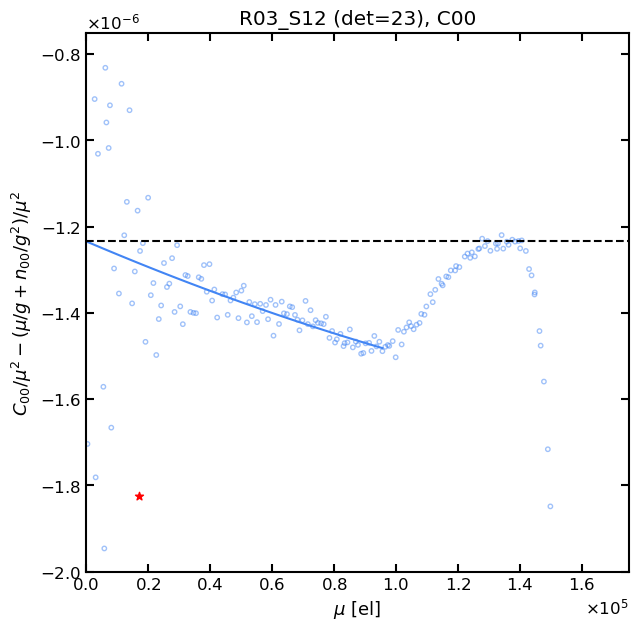

In [55]:
plt.scatter(mu*g,r, marker="o", edgecolor="#4285F4", s=10,  facecolor="None", label="135211 (blue)", alpha=0.5)
plt.plot(mu[expIdMask]*g,r_model[expIdMask], "o-", ms=0, c="#4285F4")
plt.axhline(a[0,0], linestyle="--", color="k")

r_ = (varDiff_ / mu_**2) - (mu_/g + n/g**2)/(mu_**2)
print([mu_*g], [-r_[0][0]])
plt.scatter([mu_*g], [-r_[0][0]], marker="*", color="r")# facecolor="w",edgecolor="r")


plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
plt.ylim(-2.0e-6,-.75e-6)
plt.xlim(0,1.75e5)
plt.xlabel(r"$\mu$ [el]")
plt.title(f"{det_name} (det={det}), {AMP}")
plt.ylabel("$C_{00}/\mu^2 - (\mu/g + n_{00}/g^{2})/\mu^2$")

(-1.0, 2.0)

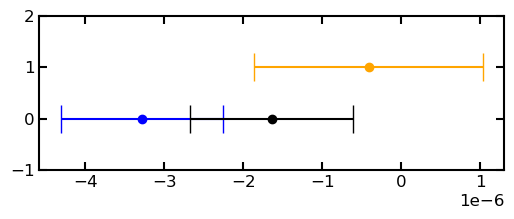

In [33]:
plt.figure(figsize=(6,2))
plt.errorbar(x=[-3.28e-6], y=[0], 
             xerr = [1.03e-6],
            marker="o", color="b",capsize=10)
plt.errorbar(x=[-1.64e-6], y=[0], 
             xerr = [1.03e-6],
            marker="o", color="k", capsize=10)
plt.errorbar(x=[-4.13e-7], y=[1], 
             xerr = [1.45e-6],
            marker="o", color="orange", capsize=10)
plt.ylim(-1,2)